<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_6/NN_FeedForward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from matplotlib import style
plt.style.use('seaborn-talk')

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_reg_predict(x, w, b ):
#     print(x.shape)
#     print(w.shape)
    return sigmoid( np.dot(w , x) + b )


def cross_entropy(y, a, noise = 10e-5):
    y_in = y.reshape(-1)
    a_in = a.reshape(-1)
    n_s = len(y_in )
    return -np.dot( y_in, np.log(a_in+ noise  ).T )/n_s - np.dot((1-y_in),np.log( (1-a_in) + noise  ).T )/n_s    

# Neural Network (NN): feedforward

## Combination of Logistic Regression

Now consider the situation where two logistic regressions are compined to make a new estimator. 

That is, LR1 is applied to that innput features  and determine the probabilities of different classes. Then LR2 takes these probabilities as an input and based on that determine the probabilities of  a second classification problem. 
The computation graph would look like

![alt text](https://www.dropbox.com/s/9o01doidvs6hmj9/computationGraph_LR_simplified_multi_layer.png?dl=1)  
  
For charachterization of this estimator, we need two sets of W and B matrices, one for the LR1 and one for LR2. We use the following notation for that:

W<sup>[1]</sup> => Weights for LR1

B<sup>[1]</sup> => Biases for LR1

W<sup>[2]</sup> => Weights for LR1

W<sup>[2]</sup> => Biases for LR1

As discussed before, W<sup>[1]</sup> is 

{ w<sup>[1]</sup><sub>1</sub>, b<sub>1</sub> } => Class 1

{ w<sup>[1]</sup><sub>2</sub>, b<sub>2</sub> } => Class 2

{ w<sup>[1]</sup><sub>3</sub>, b<sub>3</sub> } => Class 3

So, each w<sup>[j]</sup><sub>i</sub> is a vector and each b<sup>[j]</sup><sub>i</sub> is a number and they correspond to classification of class i for LR_j. 

Use what we haev done so far to implement this! 

(Optional) Design your function such that it work for n_s samples. 

In [12]:
'''
X.shape => (n_f, n_s)
w_i : (n_l, n_l-1 )
b_i : (n_l, 1)
Y.shape => (1, n_s)
'''
def NN_forward(X, w_list, b_list):
    a = []
    a += [X]
    for i in range(len(w_list)):
        a += [log_reg_predict(a[-1], w_list[i], b_list[i])]
  
    return a    

In [42]:
n_s = 10000  # number of samples
n_outputs = 1
n_f = 2
n_l = [n_f, 5, 6, n_outputs ]

x = np.random.uniform(-5,5,size=[n_f,n_s])
w_list = [ np.random.uniform(-1,1,size=[ n_l[i+1] , n_l[i] ] ) for i in range(len(n_l) - 1 )  ]
b_list = [ np.random.uniform(-1,1,size=[  n_l[i+1], 1  ]) for i in range(len(n_l) - 1 )  ]


a = NN_forward(x, w_list, b_list)
a[-1].shape


(1, 10000)

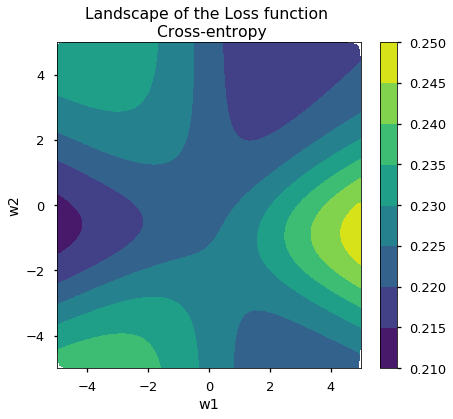

In [43]:
# This makes highly non-linear functions. 

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,title = 'Landscape of the Loss function \n Cross-entropy', xlabel='w1', ylabel='w2')

p1 = ax.tricontourf(x[0], x[1], a[-1].reshape(-1))
plt.colorbar(p1)

plt.show()

## Functions for Feedforward

In [49]:
'''
The same as log_reg_predict. The only difference is that 
we let it take the activation function as an input. 
Also note that here, x is not neccessarily the input, but 
could be the output of any of the previous layers. 

The input shapes are
x: (n_f, n_s)
w_list: {w_l :  ( n_(l), n_(l-1) ) }
b_list: {b_l :  ( n_(l), 1 ) }
'''
def single_layer(x, w, b ,  activation_func=(lambda x: sigmoid(x)  ) ):
    z = np.dot( w, x) + b
    return z , activation_func( z )

'''
We now define our general neural network function. 

The input shapes are
x: (n_f, n_s)
w_list: {w_l :  ( n_(l), n_(l-1) ) }
b_list: {b_l :  ( n_(l), 1 ) }

We return both z and a in all the layers for the output. 
This could be too much for a real data!!

'''
def NN_forward(x, w_list, b_list, activation_func_list=[(lambda x: sigmoid(x))]  ):
    a = x
    z_list = []
    a_list = [a]
    if len(activation_func_list) == 1:  ##Apply the same function to all layers.
        for i in range(len(w_list)):
            z, a = single_layer(a , w_list[i], b_list[i] , activation_func_list[0] )
            z_list += [ z ]
            a_list += [ a ]
    else:                              ##Apply a differnt function to each layer.
        for i in range(len(w_list)):
            z, a = single_layer(a , w_list[i], b_list[i] , activation_func_list[i] )
            z_list += [ z ]
            a_list += [ a ]
      
    return a_list, z_list
  

def NN_func(w_list, b_list,  activation_func_list=[(lambda x: sigmoid(x)) ] ):
    def func(x):
        return NN_forward(x, w_list, b_list, activation_func_list)
    return(func)

### Some simple toy models
Let's see how this function works and what it can genereate. We try different depth for the function at this stage.

In [95]:
'''
This will make a random network based on the nodes in each layer.
The inputs are
nl_list = [n_f, n_l1, n_l2, ..., n_c]: with n_li the number of nodes in layer i. 

We could add 
activation_func_list = [act_func_1, act_func_2, ... ]
But for now, we keep it simple. 

'''

def random_network_generator( nl_list ):
    w_list = []
    b_list = []
    for i in range(len(nl_list)-1 ):
        w_list += [ np.random.uniform(-1,1,size=[nl_list[i+1] , nl_list[i] ]) ]
        b_list += [ np.random.uniform(-1,1,size=[ nl_list[i+1], 1 ]) ]
    return w_list, b_list

In [135]:
'''
We want to make a 2D grid and see what the NN does to each point. 
This is the main reason we set n_f = 2. 
'''
## Generate the grid
n_points = 40  ## Number of points along each axis of the grid. 
xrange=np.linspace(-10,10,n_points)  ## We let the two features change from between -10 and 10 and we pick 40 points to sample.
X0,X1=np.meshgrid(xrange,xrange)

'''
Let's start with a simple Logistic Regression with two features for the input data!
'''
nl_list = [2, 3,1]
ws, bs = random_network_generator(nl_list)


## And the NN function
nn_f = NN_func(ws, bs , activation_func_list=[(lambda x: sigmoid(x))] ) ## For now, we use f(x)=x for activation. 


In [136]:
input_x = np.array([X0, X1])
print('The input has a shape of: {}'.format(input_x.shape))

Z  = nn_f(input_x.reshape(nl_list[0], -1) )
# Z has multiple indices. First, there is the layer
# First => a vs Z, Second=> Layer, third=>Nodes in layer  and finally the samples. 
output = Z[0][-1].reshape(nl_list[-1] , n_points, n_points)
print(f'The output has a shape of: {output.shape}')

The input has a shape of: (2, 40, 40)
The output has a shape of: (1, 40, 40)


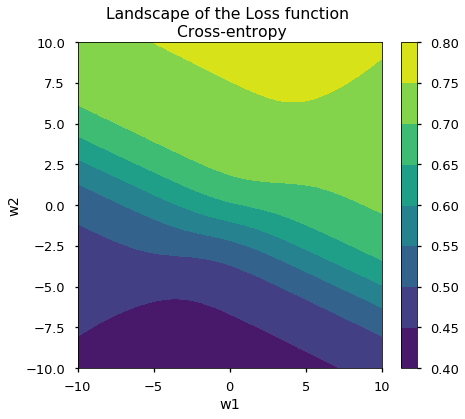

In [137]:
# This makes highly non-linear functions. 

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,title = 'Landscape of the Loss function \n Cross-entropy', xlabel='w1', ylabel='w2')

p1 = ax.tricontourf(input_x[0].reshape(-1), input_x[1].reshape(-1), output.reshape(-1))
plt.colorbar(p1)

plt.show()

### No-Activation

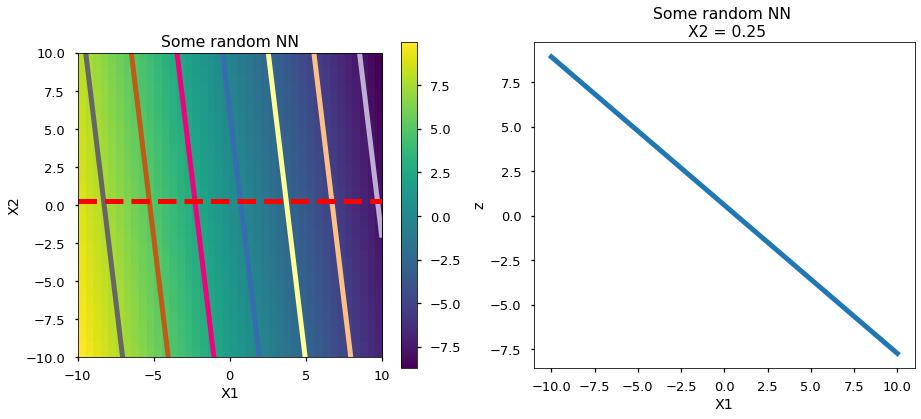

In [142]:
## Generate a random network
nl_list=[2,1]
ws, bs = random_network_generator(nl_list)

## And the NN function
nn_f = NN_func(ws, bs , activation_func_list=[(lambda x: x)] ) ## For now, we use f(x)=x for activation. 
z =nn_f(input_x.reshape(nl_list[0], -1) )[0][-1].reshape(n_points,n_points)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, xlabel='X1', ylabel='X2', title='Some random NN')
plt.imshow(z,interpolation='nearest',origin='lower', extent=(-10,10,-10,10) , cmap=plt.cm.viridis )
plt.colorbar()
plt.contour(X0, X1, z, cmap = plt.cm.Accent, linewidths=5)
ax.axhline(y=.25, color='r', linestyle='--', linewidth=5)

ax = fig.add_subplot(122, xlabel='X1', ylabel='z', title='Some random NN \n X2 = 0.25')
ax.plot(X0[20], z[20], linewidth=5)

plt.show()
plt.close()

### With Sigmoid Activation- single layer

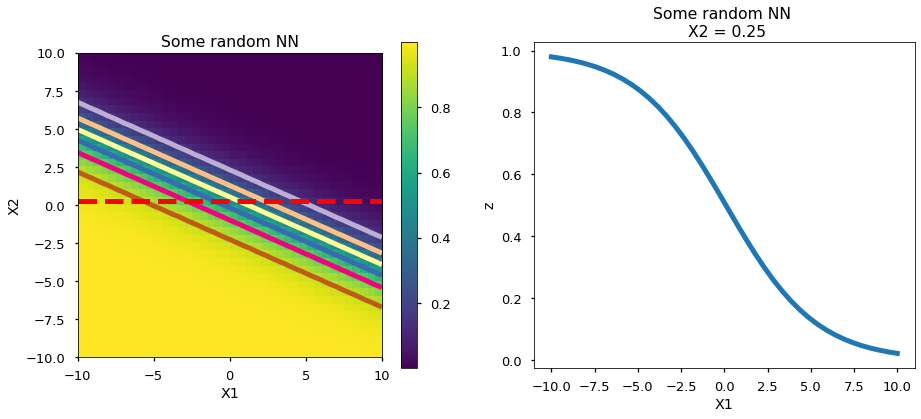

In [143]:
## Generate a random network
nl_list=[2,1]
ws, bs = random_network_generator(nl_list)

## And the NN function
nn_f = NN_func(ws, bs , activation_func_list=[(lambda x: sigmoid(x))] ) ## For now, we use f(x)=x for activation. 
z =nn_f(input_x.reshape(nl_list[0], -1) )[0][-1].reshape(n_points,n_points)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, xlabel='X1', ylabel='X2', title='Some random NN')
plt.imshow(z,interpolation='nearest',origin='lower', extent=(-10,10,-10,10) , cmap=plt.cm.viridis )
plt.colorbar()
plt.contour(X0, X1, z, cmap = plt.cm.Accent, linewidths=5)
ax.axhline(y=.25, color='r', linestyle='--', linewidth=5)

ax = fig.add_subplot(122, xlabel='X1', ylabel='z', title='Some random NN \n X2 = 0.25')
ax.plot(X0[20], z[20], linewidth=5)

plt.show()
plt.close()

### With Sigmoid Activation- more layers

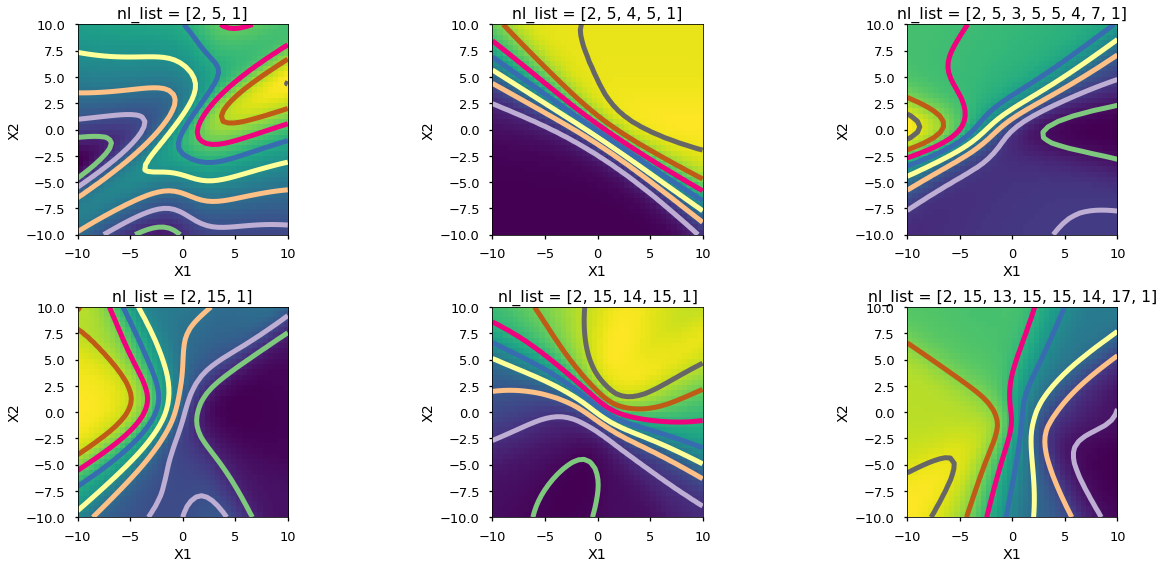

In [148]:
fig = plt.figure(figsize=(18,8))
nl_list_list = [ [2,5,1],[2,5, 4, 5,1],[2,5, 3,5,5,4 , 7,1],    [2,15,1],[2,15, 14, 15,1],[2,15, 13,15,15,14 , 17,1]  ]
i=0

for nl_list in nl_list_list:
    i+=1
    ax = fig.add_subplot(2,3,i, xlabel='X1', ylabel='X2', title='nl_list = {}'.format(nl_list ) )

    ## Generate a random network
    ws, bs = random_network_generator( nl_list )

    ## And the NN function
    nn_f = NN_func(ws, bs , activation_func_list=[(lambda x: sigmoid(x))] ) ## For now, we use f(x)=x for activation. 
    z =nn_f(input_x.reshape(nl_list[0], -1) )[0][-1].reshape(n_points,n_points)

    ## Plotting
    plt.imshow(z,interpolation='nearest',origin='lower', extent=(-10,10,-10,10) , cmap=plt.cm.viridis )
    #   plt.colorbar()
    plt.contour(X0, X1, z, cmap = plt.cm.Accent, linewidths=5)

  

plt.tight_layout()
plt.show()

## Activation Functions

Here we go through some of the more popular activation functions.

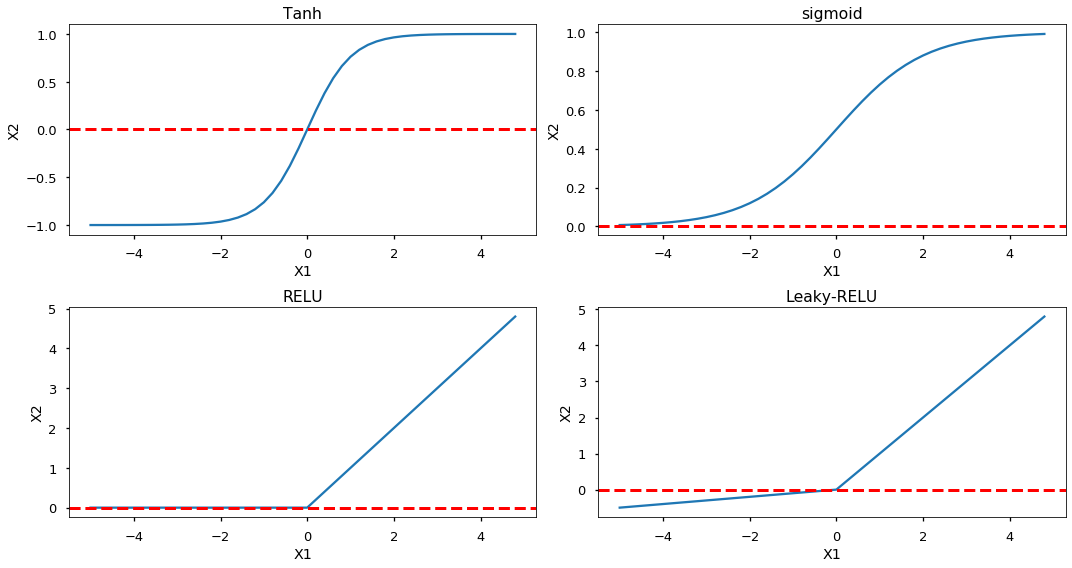

In [152]:
x_list = np.arange(-5,5,.2) 

activation_function_dict = {'Tanh': (lambda x: np.tanh(x)) , 'sigmoid': (lambda x: sigmoid(x)), 
                            'RELU': (lambda x: np.maximum(0, x)), 'Leaky-RELU': (lambda x: np.maximum(0, x)+.1*np.minimum(0, x)) }


fig = plt.figure(figsize=(15,8))
i=0

for act_func in activation_function_dict.keys():
    i+=1
    ax = fig.add_subplot(2,2,i, xlabel='X1', ylabel='X2', title='{}'.format(act_func ) )
    ax.hlines

    ## Plotting
    plt.plot(x_list,activation_function_dict[act_func](x_list) )
    ax.axhline(y=0, color='r', linestyle='--', linewidth=3)
  
plt.tight_layout()
plt.show()